# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [823]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pl.Config().set_tbl_rows(100)
pl.Config().set_tbl_cols(100)

polars.config.Config

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [824]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [825]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Мы получили вероятности того, что $i-$й признак относится к положительному классу, по которой мы как раз и будем определять какие в какой класс отправлять 

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [826]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


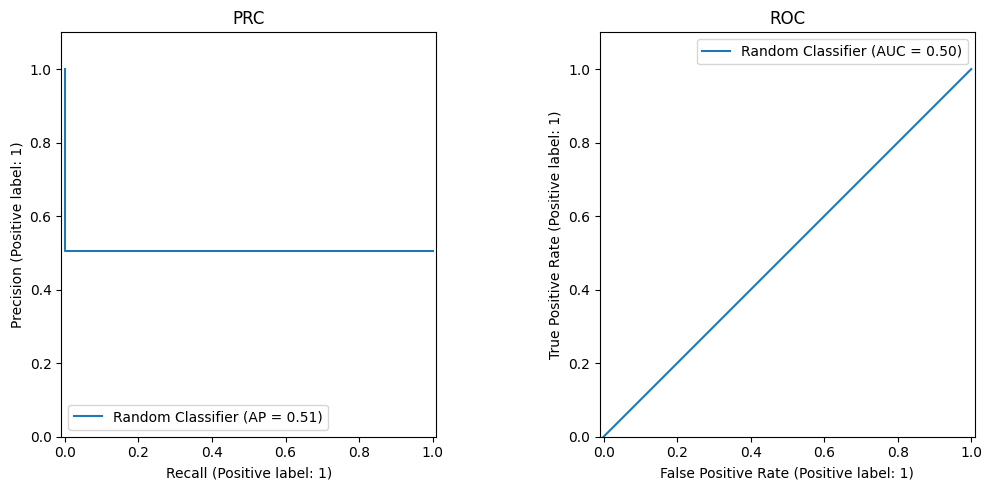

In [827]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [828]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [829]:
from sklearn.svm import LinearSVC

X_test_, X_val, y_test_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=52)
Cs = np.logspace(-5, 0, 50)
best_score = 0
best_c = 0

for C in Cs:
    svc = LinearSVC(random_state=52, C=C, tol=1e-5)
    model = svc.fit(X_train, y_train)
    prediction = model.decision_function(X_val)
    aucpr = average_precision_score(y_val, prediction)
    if (aucpr > best_score):
        best_score = aucpr
        best_c = C
print(f'best auc-pr score = {best_score}')
print(f'best reguralization constant: {best_c}')

best auc-pr score = 0.8051179624669502
best reguralization constant: 3.237457542817647e-05


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

In [830]:
svc = LinearSVC(random_state=52, C=best_c, tol=1e-5)
model = svc.fit(X_train, y_train)
prediction1 = model.decision_function(X_test)

SVC Classifier metrics
AUC-PR: 0.8317
AUC-ROC: 0.8416


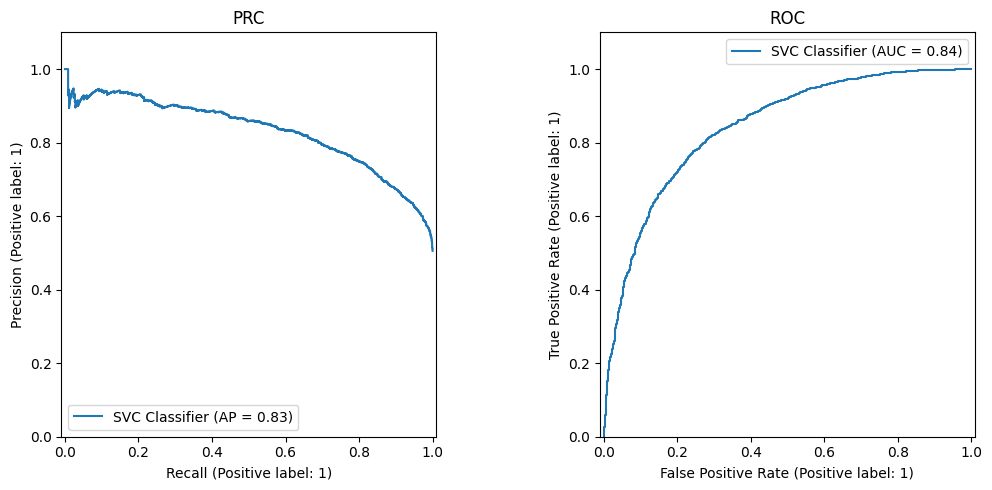

In [831]:
depict_pr_roc(y_test, prediction1, 'SVC Classifier')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

При увеличении порога в сравнении с идеальной моделью $AUC-ROC$ в нашей иногда проскакивают отрицательные классы, которые наклоняют кривую, говоря об ошибках модели, но в целом кривая не близка к кривой с тангенсом угла наклона 1, поэтому можно сказать что она относительно адекватна.

По поводу $PRC$ вначале Precision высокий, а Recall близок к нулю, то есть угадывали очень мало правильно, но вообще не покрыли положительный класс. Далее с увеличением порога Precision в начале происходит какая-то шиза, то есть мы резко теряем доверие к нашим предсказаниям захватывая отрицательные объекты которые могут быть выбросам, потом получаем больше положительных объектов в область, которую называем положительной, поэтому precision немного увеличивается, а потом логично при увеличении порога мы начинаем все больше захватывать отрицательных объектов, но увеличиваем покрытие положительного класса поэтому precision падает, а recall растет 

Кривые монотонны, так как в $PRC$ мы находимся в осях Recall-Precision, которые отрицательно коррелированы, то есть при увеличении одного падает другое, что мы и видем на графике. Если мы увеличиваем покрытие положительного класса (recall), то к нам попадают отрицательные объекты, которые мы считаем подложительными и precision падает. В $AUC-ROC$ при сдвиге порога всегда увеличивается либо $TPR$ на $\frac{1}{\ell_{+}}$ либо $FPR$ на $\frac{1}{\ell_{-}}$, поэтому кривая монотонно неубывает 

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
SVC Classifier metrics
AUC-PR: 0.8317
AUC-ROC: 0.8416


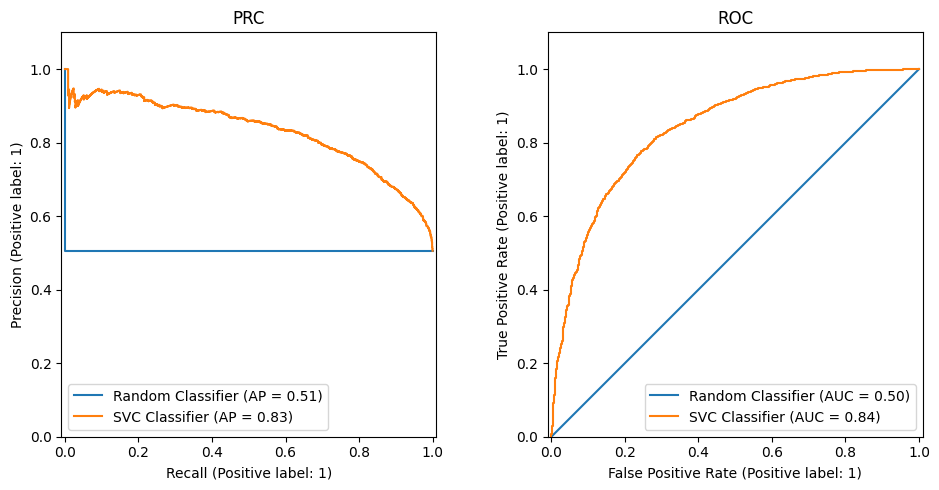

In [832]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)
depict_pr_roc(y_test, prediction1, 'SVC Classifier', ax=ax)

Обе метрики больше, очевидно, что обученная модель работает лучше чем рандомный классификатор лол 

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [833]:
from sklearn.linear_model import LogisticRegression
best_score = 0
best_c = 0

for C in Cs:
    lr = LogisticRegression(random_state=52, C=C)
    model = lr.fit(X_train, y_train)
    prediction = model.decision_function(X_val)
    aucpr = average_precision_score(y_val, prediction)
    if (aucpr > best_score):
        best_score = aucpr
        best_c = C
print(f'best auc-pr score = {best_score}')
print(f'best reguralization constant: {best_c}')

best auc-pr score = 0.8074142782947817
best reguralization constant: 0.0006866488450042998


In [834]:
lr = LogisticRegression(random_state=52, C=best_c)
model = lr.fit(X_train, y_train)
prediction2 = model.decision_function(X_test)

Logistic Regression Classifier metrics
AUC-PR: 0.8343
AUC-ROC: 0.8444


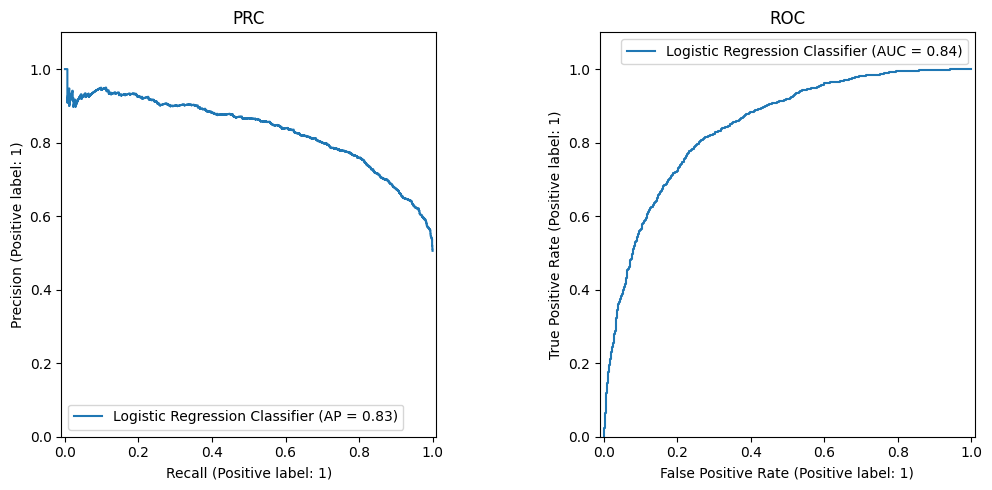

In [835]:
depict_pr_roc(y_test, prediction2, 'Logistic Regression Classifier')

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
Logistic Regression Classifier Classifier metrics
AUC-PR: 0.8343
AUC-ROC: 0.8444


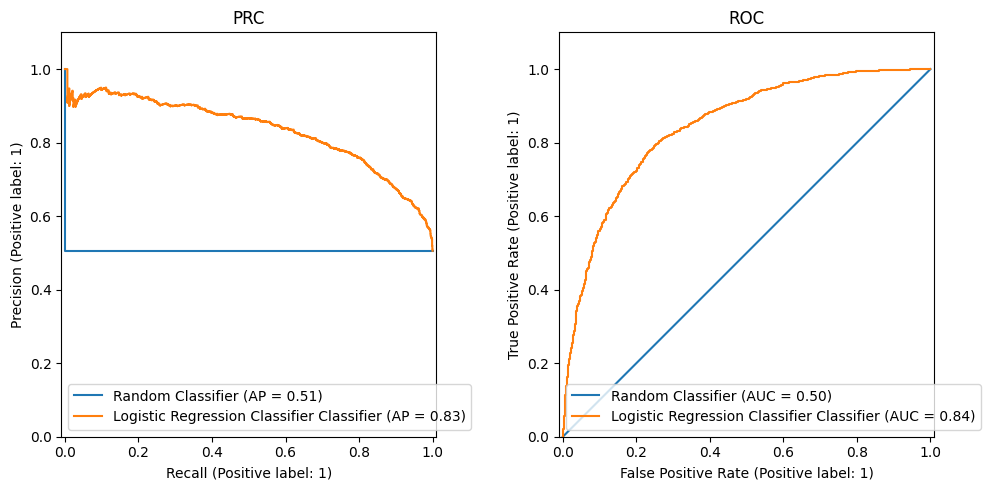

In [836]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)
depict_pr_roc(y_test, prediction2, 'Logistic Regression Classifier Classifier', ax=ax)

Невероятно, но факт, тут тоже результаты лучше 

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
SVC Classifier metrics
AUC-PR: 0.8317
AUC-ROC: 0.8416
Logistic Regression Classifier Classifier metrics
AUC-PR: 0.8343
AUC-ROC: 0.8444


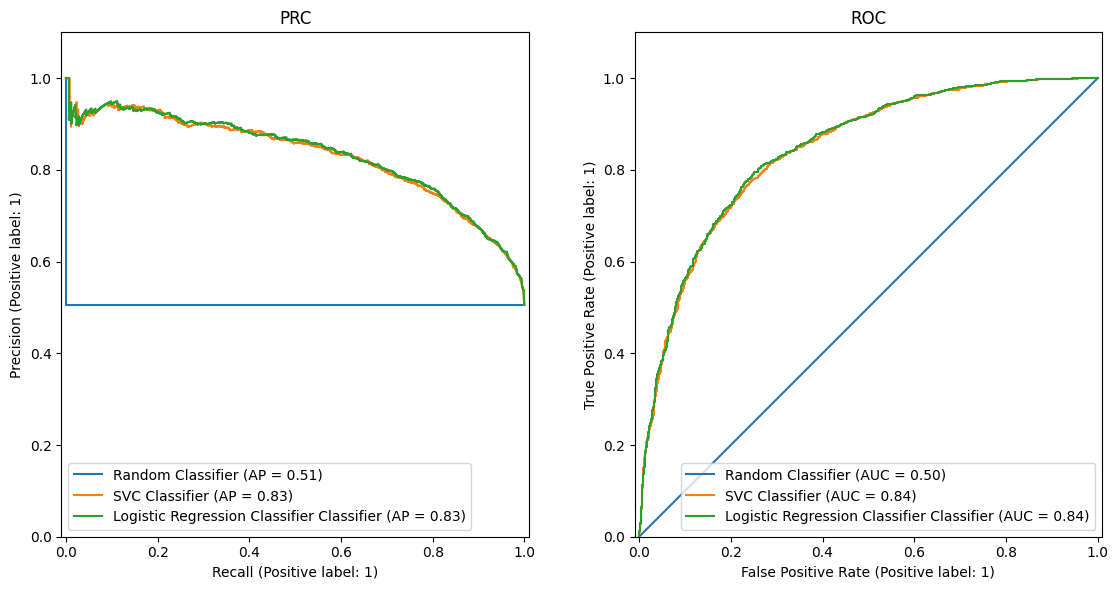

In [837]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)
depict_pr_roc(y_test, prediction1, 'SVC Classifier', ax=ax)
depict_pr_roc(y_test, prediction2, 'Logistic Regression Classifier Classifier', ax=ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Различий почти нет

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [838]:
from sklearn.svm import SVC
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42
)

svc = SVC(random_state=52, kernel='linear')
model = svc.fit(X, y)


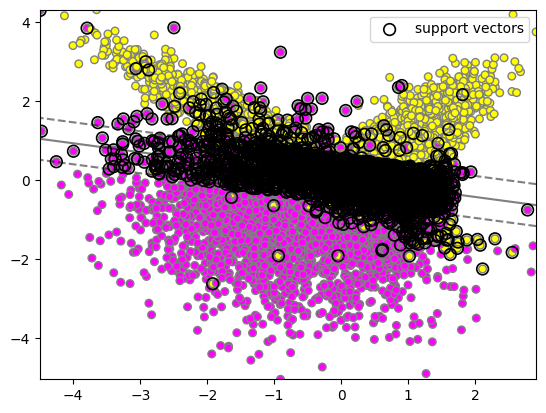

In [839]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)
    
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        X[:, 0],
        X[:, 1], 
        c=y, 
        cmap='spring',
        edgecolors="gray",
        s=30, 
    )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            svc.support_vectors_[:, 0],
            svc.support_vectors_[:, 1],
            edgecolors="black",
            label='support vectors',
            s=70,
            linewidth=1.2,
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Ближайшие к разделяющей гиперплоскости и те, которые оказались по ту сторону баррикады (не в том классе), то есть грубо говоря выбросы 

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [840]:
lr = LogisticRegression(random_state=52)
model = lr.fit(X, y)

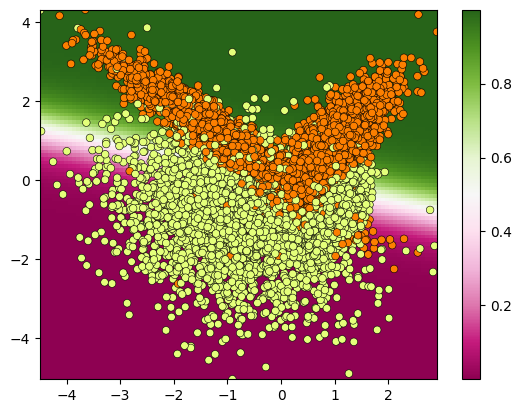

In [841]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap="PiYG",
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0],
        X[:, 1], 
        c=y, 
        s=30, 
        cmap='Wistia',
        edgecolors='black',
        linewidths=0.4
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Белая область, это разделяющая линия, которая как раз примерно совпадает с гиперплоскостью из метода главных компонент, векторы близкие к разделяющему получают вероятность близкую к 50 на 50 я хз что тут еще сказать надо  

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [842]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot(np.linspace(-0.05, 1.05, len(bin_middle_points)), np.linspace(-0.05, 1.05, len(bin_middle_points)))
    plt.ylim([-0.05, 1.05])
    plt.grid()
    return plt

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

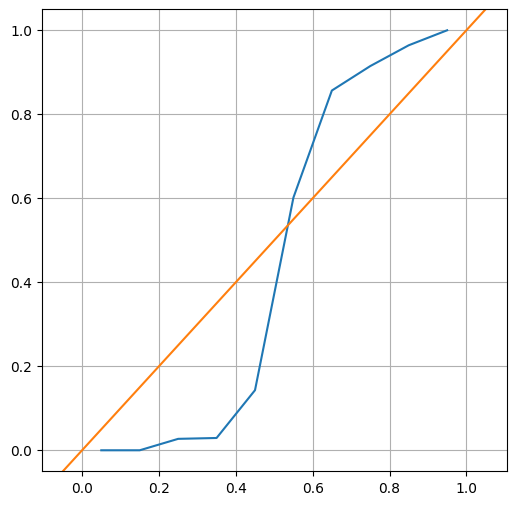

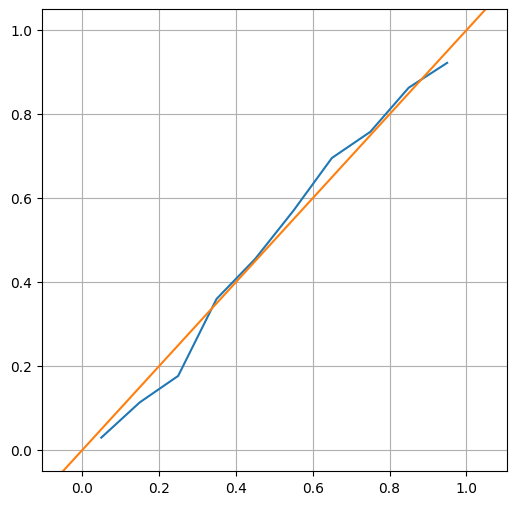

In [ ]:
from scipy.special import expit

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=52
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

svc = SVC(random_state=52, kernel='linear')

model1 = svc.fit(X_train, y_train)
prediction1 = model1.decision_function(X_test)
prediction1 = (prediction1 - prediction1.min()) / (prediction1.max() - prediction1.min()) #для SVC опции заюзать сигмоиду нет (from seminars ipynb information) поэтому пользуемся минимаксом 

lr = LogisticRegression(random_state=52)

model2 = lr.fit(X_train, y_train)
prediction2 = model2.predict_proba(X_test)[:, 1]


plot_calibration_curve(y_test, prediction1)
plot_calibration_curve(y_test, prediction2)

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:**  для логистической более менее хорошо, так как калибровочная прямая очень близка к идеальной, для SVC же все не очень хорошо, поэтому будем издеваться дальше (кривая заметно отличается от идеальной)

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [844]:
from sklearn.metrics import log_loss, brier_score_loss
logloss1 = log_loss(y_test, prediction1)
briefscore1 = brier_score_loss(y_test, prediction1)
logloss2 = log_loss(y_test, prediction2)
briefscore2 = brier_score_loss(y_test, prediction2)
print(logloss1, logloss2)
print(briefscore1, briefscore2)

0.5354478122958389 0.38758301691805697
0.17496933169115156 0.12006809613483942


Как видим, обе метрики показали лучшие результаты на второй модели, то есть в первой действительно есть проблема 

Изучите распределение ответов классификаторов при помощи гистограмм

[Text(0.5, 1.0, 'hist of Logistic Regression model predictions')]

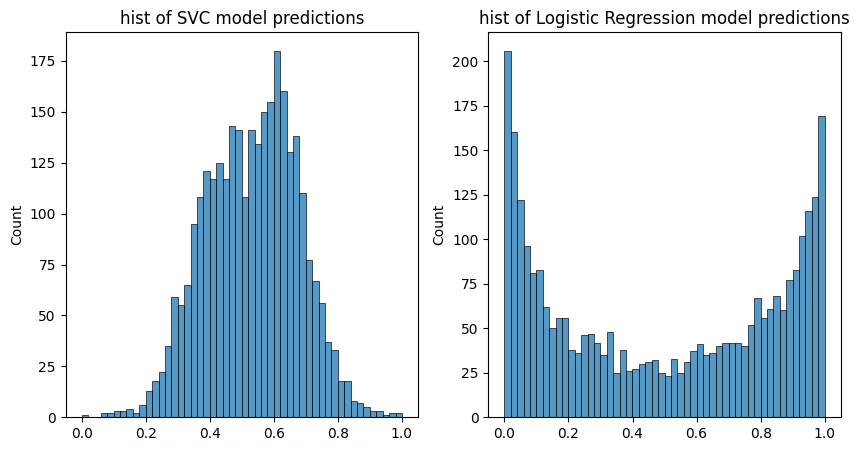

In [845]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
sns.histplot(prediction1, ax=ax1, bins=50).set(title='hist of SVC model predictions')
sns.histplot(prediction2, ax=ax2, bins=50).set(title='hist of Logistic Regression model predictions')

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** У SVC оценки распределены близко к нормальному, то есть есть большое количество объектов, в которых модель не уверена, у логистической же регрессии наоборот много объектов в которых модель сильно уверена, то есть тяжелые хвосты. Возможно это связано с тем, что минмакс скейл достаточно наивен и грубый и не является естественным эстиматором вероятности, каким является log-loss, на котором обучается логистическая регрессия и приближалась к теоретической вероятности 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

SVC ROC-AUC: 0.9064974416017797


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

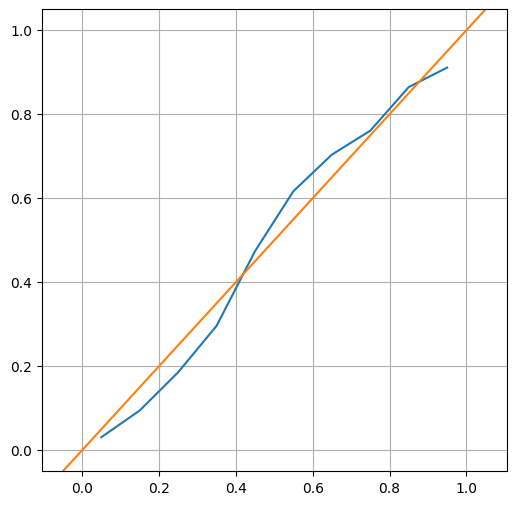

In [846]:
from sklearn.calibration import CalibratedClassifierCV
sigmoid_svc = CalibratedClassifierCV(svc, cv=5).fit(X_train, y_train) #метод = сигмоида по дефолту 
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))
plot_calibration_curve(y_test, sigmoid_svc_pred)

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Калибровочная кривая стала намного ближе к идеальной калибровке, то есть качество улучшилось 

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [1286]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [1287]:
# Прочитаем датасет
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
data = pl.read_csv(path)

# Отделим X и y
X = data.drop('ID', 'Purchased Bike')
y = (data['Purchased Bike'] == 'Yes').cast(pl.Int32)


# Разделим на категориальные признаки и числовые
X_numerical = X.drop(categorical)
X_categorical = X[categorical].fill_null('undefined') # Заменим пропуски категориальных переменных

В начале поработаем только с категориальными признаками

In [1288]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=433, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [1289]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

import time 

column_transformer = ColumnTransformer([
    ('oe', OrdinalEncoder(), categorical),
])

logistic_pipeline = Pipeline(steps=[
    ('oe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])
start = time.time()
model = logistic_pipeline.fit(X_train, y_train)
end = time.time()
prediction1 = model.decision_function(X_test)
print(f'oe auc-pr score: {average_precision_score(y_test, prediction1):.4f}')
print(f'oe time: {(end - start):.4f}')

oe auc-pr score: 0.5947
oe time: 0.0059


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [1290]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
])

logistic_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])
start1 = time.time()
model = logistic_pipeline.fit(X_train, y_train)
end1 = time.time()
prediction2 = model.decision_function(X_test)
print(f'ohe auc-pr score: {average_precision_score(y_test, prediction2):.4f} vs oe auc-pr score: {average_precision_score(y_test, prediction1):.4f}')
print(f'ohe time: {(end1 - start1):.4f} vs oe time: {(end - start):.4f}')

ohe auc-pr score: 0.6452 vs oe auc-pr score: 0.5947
ohe time: 0.0070 vs oe time: 0.0059


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [1291]:
def my_transform(X):
    X_return = X.to_pandas().copy()
    
    X_return = pl.from_pandas(X_return)
    
    concated = pl.concat([X_train, y_train.to_frame()], how='horizontal')
    
    for category in categorical:
        
        Group = concated.group_by(category).agg((pl.col('Purchased Bike').mean()).alias(category + '1'))
        
        X_return = X_return.join(Group, on = category, how='left').drop(category).rename({category + '1' : category})
        
    return X_return



start2 = time.time()
X_train_transform = my_transform(X_train)
X_test_transform = my_transform(X_test)

lr = LogisticRegression(random_state=52)
model = lr.fit(X_train_transform, y_train)
end2 = time.time()
prediction3 = model.decision_function(X_test_transform)

print(f'counts auc-pr score: {average_precision_score(y_test, prediction3):.4f}')
print(f'oe time: {(end2 - start2):.4f}')

counts auc-pr score: 0.6529
oe time: 0.0161


Короче лютый прикол, я игрался с рэндом стейт чтобы С подобралась в следующем задании и единственный, где у меня получилось это 433, но тут даже обычный мин тагрет стал лучше, поэтому да, обычно мин таргет давал более плохие результаты чем OHE и либо лучше либо хуже, чем Ordinal иногда 

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
# не 

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [1302]:
def my_transform(X, var):
    X_return = X.to_pandas().copy()
    X_return = pl.from_pandas(X_return)
    
    for category in categorical:
        
        Group = pl.concat([X_train, y_train.to_frame()], how='horizontal').group_by(category).agg((pl.col('Purchased Bike').mean()).alias(category + '1'))
        Group = Group.with_columns(pl.Series("random", np.random.normal(0, var, Group.shape[0])))
        Group = Group.with_columns((pl.col(category + '1') + pl.col("random")).alias(category + '2')).drop(category + '1') #магический код, не трогать (я больше не буду на поларсе делать обещаю)
        X_return = X_return.join(Group, on = category, how='left').drop(category, "random").rename({category + '2' : category})
        
    return X_return

var = np.logspace(-4, 0, 20) #подберем наилучшую дисперсию, чтобы посмотреть можно ли вообще получить улучшение 

lr = LogisticRegression(random_state=52)


best_auc = 0.5
best_var = 0
for var in var:
    
    X_train_transform = my_transform(X_train, var)
    X_test_transform = my_transform(X_test, var)
    model = lr.fit(X_train_transform, y_train)
    prediction4 = model.decision_function(X_test_transform)
    
    if (average_precision_score(y_test, prediction4) > best_auc):
        best_auc = average_precision_score(y_test, prediction4)
        best_var = var


start3 = time.time()
X_train_transform = my_transform(X_train, best_var)
X_test_transform = my_transform(X_test, best_var)


model = lr.fit(X_train_transform, y_train)
end3 = time.time()
prediction4 = model.decision_function(X_test_transform)


print(f'noize auc-pr score: {average_precision_score(y_test, prediction4):.4f}')
print(f'noize time: {(end3 - start3):.4f}')
print(f'best var: {best_var:.4f}')

noize auc-pr score: 0.6558
noize time: 0.0110
best var: 0.0018


читать если получилось больше: стало чуть побольше но вообще кринж какой-то, это просто повезло

читать если получилось меньше: стало чуть меньше но вообще кринж какой-то, это просто не повезло

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Так как эксперимент случайный, то можно потыкаться и увидеть, что иногда качество на тесте растет, а иногда падает, поэтому можно сказать что частично шум может помочь, так как предотвращает нелюбимое нами переобучение, но из-за добавления такой случайности мы вносим искажения в модель и поэтому результативность метрики непредсказуема

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
# не

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{globalMean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{globalMean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [1303]:

def my_transform(X, C):
    global_mean = y_train.mean()
    X_return = X.to_pandas().copy()
    
    X_return = pl.from_pandas(X_return)
    
    concated = pl.concat([X_train, y_train.to_frame()], how='horizontal')
    
    for category in categorical:
        
        Group = concated.group_by(category).agg([pl.col('Purchased Bike').sum().alias('sum_target'), pl.len().alias('count')])
        Group = Group.with_columns(((pl.col('sum_target') + C * global_mean) / (pl.col('count') + C)).alias(category + '1'))
        X_return = X_return.join(Group, on = category, how='left').drop(category, 'sum_target', 'count').rename({category + '1' : category})
        
    return X_return

best_c = 0

best_auc = average_precision_score(y_test, prediction2)

C = np.logspace(-5, 5, 10)

lr = LogisticRegression(random_state=94)

for c in C:
    X_train_transform = my_transform(X_train, c)
    X_test_transform = my_transform(X_test, c)
    model = lr.fit(X_train_transform, y_train)
    prediction5 = model.decision_function(X_test_transform)
    if (average_precision_score(y_test, prediction5) > best_auc):
        best_auc = average_precision_score(y_test, prediction5)
        best_c = c
    
start4 = time.time()
X_train_transform = my_transform(X_train, best_c)
X_test_transform = my_transform(X_test, best_c)

model = lr.fit(X_train_transform, y_train)
end4 = time.time()
prediction5 = model.decision_function(X_test_transform)

print(f'smoothed auc-pr score: {average_precision_score(y_test, prediction5):.4f}')
print(f'oe time: {(end4 - start4):.4f}')
print(f'best c: {best_c:.4f}')

smoothed auc-pr score: 0.6559
oe time: 0.0109
best c: 599.4843


я ПРаВДа ПытАлся Но Он ВышЕ шЕсТидЕсЯтИ не ПОдНиМаЕтСя (я даже тысячу цэшек прогонял все равно все спокнулось, я хотел роботов обучать на машинке господи) fjy на исходном рэндом сиде
а вот так получилась вообще лучшая оценка аук-пр 

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



[Text(0.5, 0, 'Age'), Text(0, 0.5, '')]

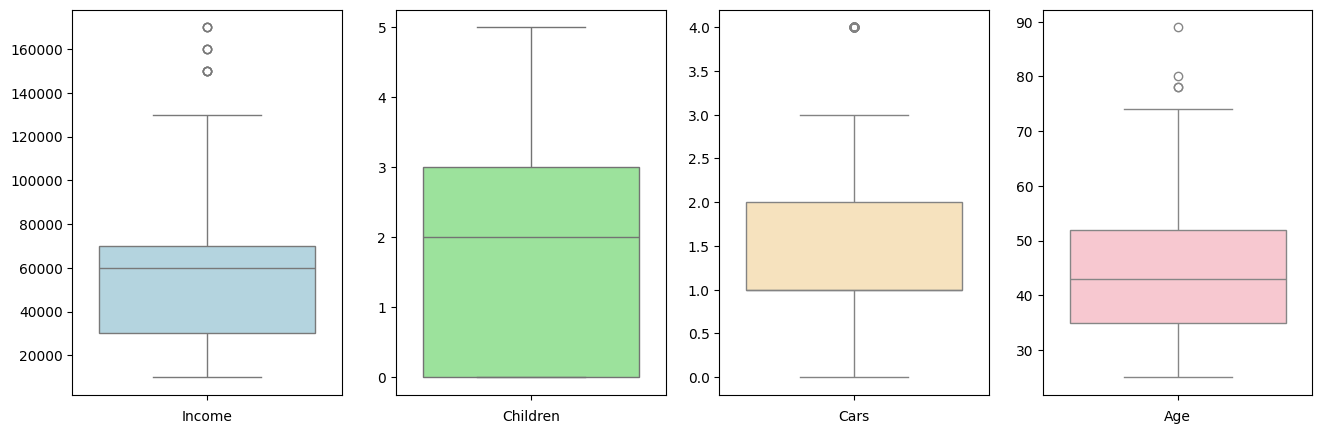

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
sns.boxplot(X_numerical['Income'].to_pandas(), ax=ax1, color='lightblue').set(xlabel='Income', ylabel='')
sns.boxplot(X_numerical['Children'].to_pandas(), ax=ax2, color='lightgreen').set(xlabel='Children', ylabel='')
sns.boxplot(X_numerical['Cars'].to_pandas(), ax=ax3, color='moccasin').set(xlabel='Cars', ylabel='')
sns.boxplot(X_numerical['Age'].to_pandas(), ax=ax4, color='pink').set(xlabel='Age', ylabel='')

Как видим, выбросы присутствуют.

Посмотрим на гистограммы

<Axes: xlabel='Age', ylabel='Count'>

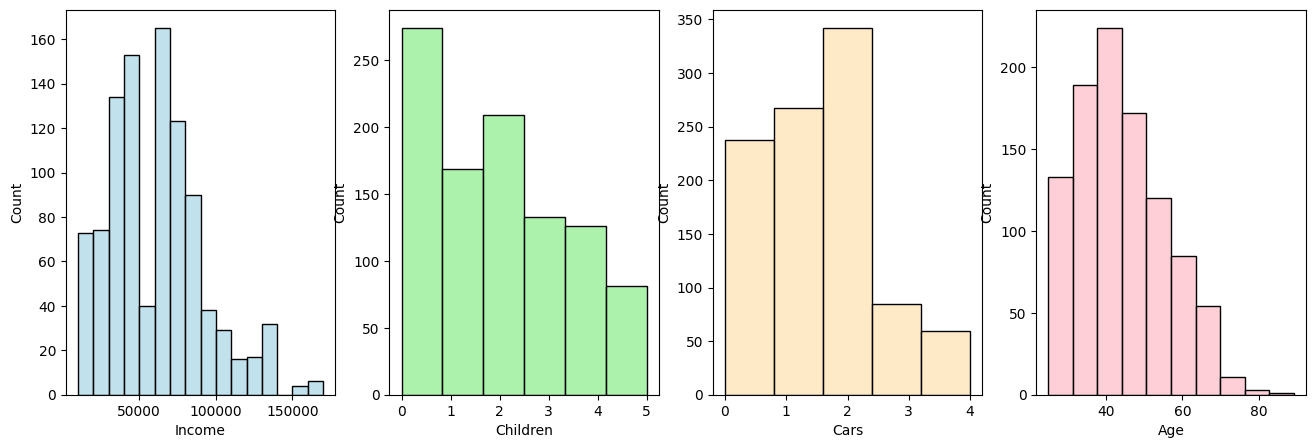

In [1008]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
sns.histplot(X_numerical['Income'].to_pandas(), ax=ax1, color='lightblue', bins=16)
sns.histplot(X_numerical['Children'].to_pandas(), ax=ax2, color='lightgreen', bins=6)
sns.histplot(X_numerical['Cars'].to_pandas(), ax=ax3, color='moccasin', bins=5)
sns.histplot(X_numerical['Age'].to_pandas(), ax=ax4, color='pink', bins=10)

Видим, что графики скошены, поэтому заполним медианой, которая более устойчива к выбросам.

In [1129]:
X_numerical = X_numerical.with_columns(pl.all().fill_null(pl.all().median()))

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [1130]:
X_numerical.with_columns(pl.all().n_unique()).head(1)

Income,Children,Cars,Age
u32,u32,u32,u32
16,6,5,53


In [ ]:
my_data = pl.concat([X_numerical, X_categorical], how='horizontal')
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(my_data, y, test_size=0.25, random_state=433, stratify=y)

def my_transform2(X, C):
    global_mean = y_train.mean()
    X_return = X.to_pandas().copy()
    
    X_return = pl.from_pandas(X_return)
    
    concated = pl.concat([X_train_all, y_train_all.to_frame()], how='horizontal')
    
    
    for category in X.columns:

        Group = concated.group_by(category).agg([pl.col('Purchased Bike').sum().alias('sum_target'), pl.len().alias('count')])

        Group = Group.with_columns(((pl.col('sum_target') + C * global_mean) / (pl.col('count') + C)).alias(category + '1'))
        X_return = X_return.join(Group, on = category, how='left').drop(category, 'sum_target', 'count').rename({category + '1' : category})
        
    return X_return
lr = LogisticRegression(random_state=94, max_iter=1000)

start5 = time.time()
X_train_transform = my_transform2(X_train_all, best_c)
X_test_transform = my_transform2(X_test_all, best_c)
X_test_transform = X_test_transform.fill_null(0)

model = lr.fit(X_train_transform, y_train_all)
end5 = time.time()
prediction6 = model.decision_function(X_test_transform)

print(f'oe auc-pr score: {average_precision_score(y_test_all, prediction6):.4f}')
print(f'oe time: {(end5 - start5):.4f}')


oe auc-pr score: 0.7023
oe time: 0.0172


С подходящей C модель стала лучшей по AUC-PR 

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Нам требуется меньше памяти поэтому можем работать с большими датасетами благодаря счетчикам. Также может вырасти качество, но в какой-то мере мы пользуемся ликом таргета, поэтому потенциально можем переобучиться, в этом плане $OHE$ стабильнее

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [1755]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-29 14:51:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data.3»

adult.data.3            [      <=>           ]   3,79M  2,37MB/s    за 1,6s    

2024-11-29 14:51:57 (2,37 MB/s) - «adult.data.3» сохранён [3974305]



In [1756]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
20983,36,Private,267556,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,4064,0,40,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [1757]:
X = df.drop('income', axis=1) # меня задолбал поларс поэтому я перешел тут на пандас 
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [1758]:
column_transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
    ],
    remainder='passthrough'
)
X_train_transform = column_transformer.fit_transform(X_train)
X_test_transform = column_transformer.transform(X_test)
X_train_transform.shape

(24420, 108)

Получили 108 новых признаков

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

ohe auc-pr score: 0.7639
OHE metrics
AUC-PR: 0.7639
AUC-ROC: 0.9035


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


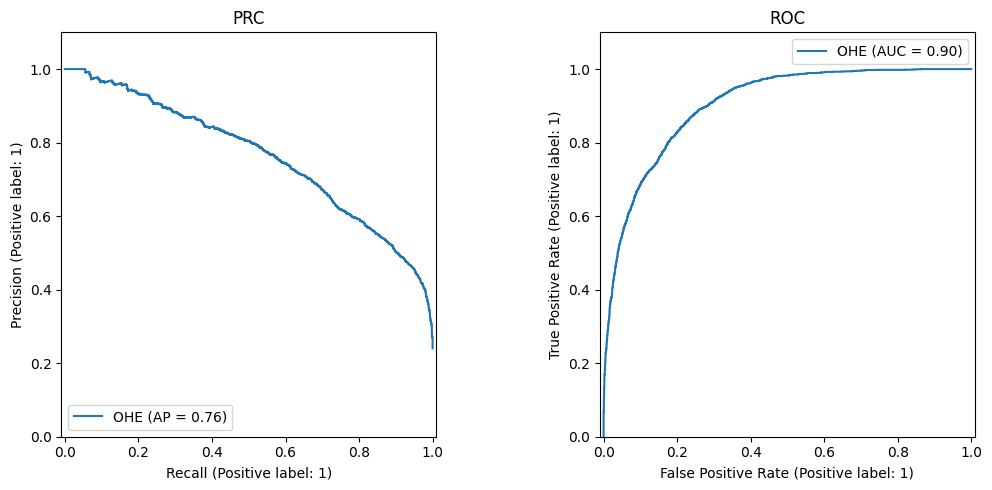

In [1759]:
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train_transform, y_train)

prediction = model.decision_function(X_test_transform)
print(f'ohe auc-pr score: {average_precision_score(y_test, prediction):.4f}')
depict_pr_roc(y_test, prediction, 'OHE')

запоминаем 0.7639

Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [1729]:
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2, random_state=777, stratify=y_train)
assert(X_train_.shape[0] == y_train_.shape[0])
assert(X_val_.shape[0] == y_val_.shape[0])


Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


auc-pr score: 0.6734
time: 0.0001
embedded method metrics
AUC-PR: 0.6734
AUC-ROC: 0.8771


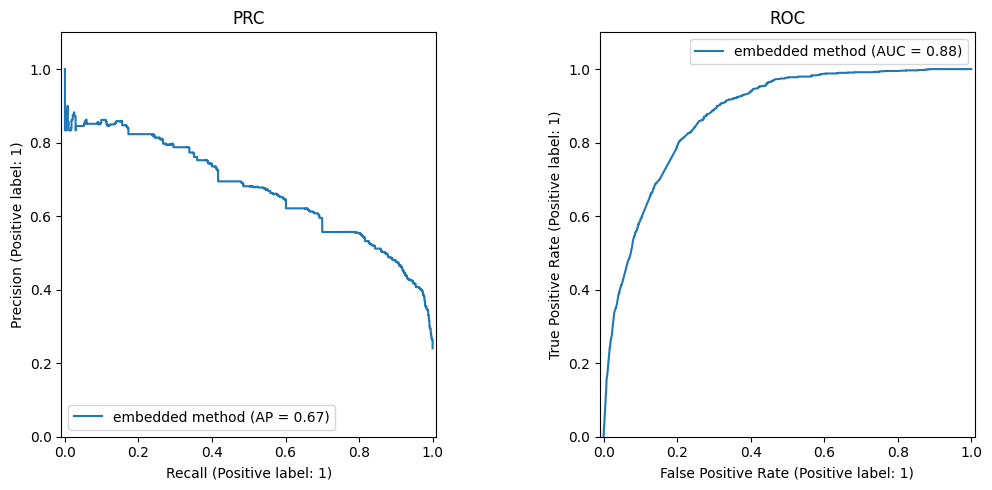

In [1730]:
X_train_transform_ = column_transformer.fit_transform(X_train_)
X_val_transform_ = column_transformer.transform(X_val_)

model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train_transform_, y_train_)

start = time.time()

w = model.coef_[0].copy()
right_indexes = np.argsort(np.abs(w))[-40:]

end = time.time()


model.fit(X_train_transform_[:, right_indexes], y_train_)

prediction = model.decision_function(X_val_transform_[:, right_indexes])
print(f'auc-pr score: {average_precision_score(y_val_, prediction):.4f}')
print(f'time: {(end - start):.4f}')
depict_pr_roc(y_val, prediction, 'embedded method')


Изменилось ли качество? Как?

Качество упало, потому что мы грубо обрезали признаки и потеряли нужные нам связи. Но упало несильно, так что наверное мы все-таки дропнули мешающие нам признаки.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

auc-pr score all features scaled: 0.773402
auc-pr score top40 scaled: 0.741500
[ 77  95  70  85  42  53  16  31   1   8  90  22  25  65  43  45 104  93
  61  71  84  49  96  28  66  82  40  36  30  58  62  52  50  37  29  64
  27  41  26 105]
top 40 scaled metrics
AUC-PR: 0.7415
AUC-ROC: 0.8966


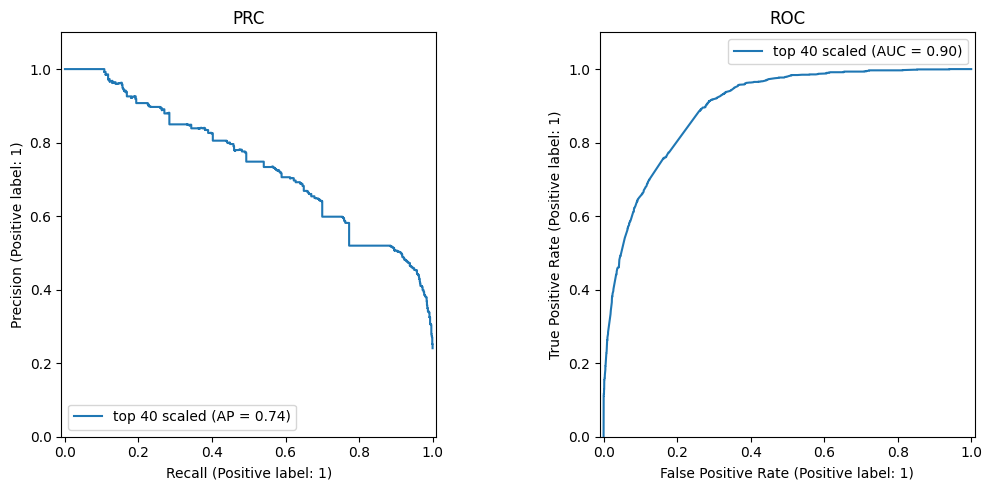

In [1732]:
categoical = X_train_.select_dtypes('object').columns
numerical = X_train_.select_dtypes('int64').columns
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categoical),
    ('scaling', StandardScaler(), numerical)
])

logistic_pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=10000, random_state=42))
])

model = logistic_pipeline.fit(X_train_, y_train_)
y_pred = model.decision_function(X_val_)
print(f'auc-pr score all features scaled: {average_precision_score(y_val_, y_pred):.6f}')

X_train_transform_ = column_transformer.transform(X_train_)
X_val_transform_ = column_transformer.transform(X_val_)

final_step = model.steps[-1][1]

# Получаем коэффициенты
w = final_step.coef_[0].copy()

right_indexes = (np.argsort(np.abs(w)))[-40:]

model = LogisticRegression(max_iter=10000, random_state=42)

model.fit(X_train_transform_[:, right_indexes], y_train_)
prediction = model.decision_function(X_val_transform_[:, right_indexes])
print(f'auc-pr score top40 scaled: {average_precision_score(y_val_, prediction):.6f}')
print(right_indexes)
depict_pr_roc(y_val, prediction, 'top 40 scaled')

Невероятно, метрики улучшились, топ40 на валидации стал выдавать намного лучше результаты, чем в самом начале

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

auc-pr score all scaled: 0.7686
[ 14  43  20  49   6  64  28  45  31  51  88  38   1  10   8  47  23  42
  19  18  21  30  58  59  37  52  48  25  36 106  40  50 102  41 107 104
  22  29  27 105]
top 40 scaled all metrics
AUC-PR: 0.7686
AUC-ROC: 0.9067


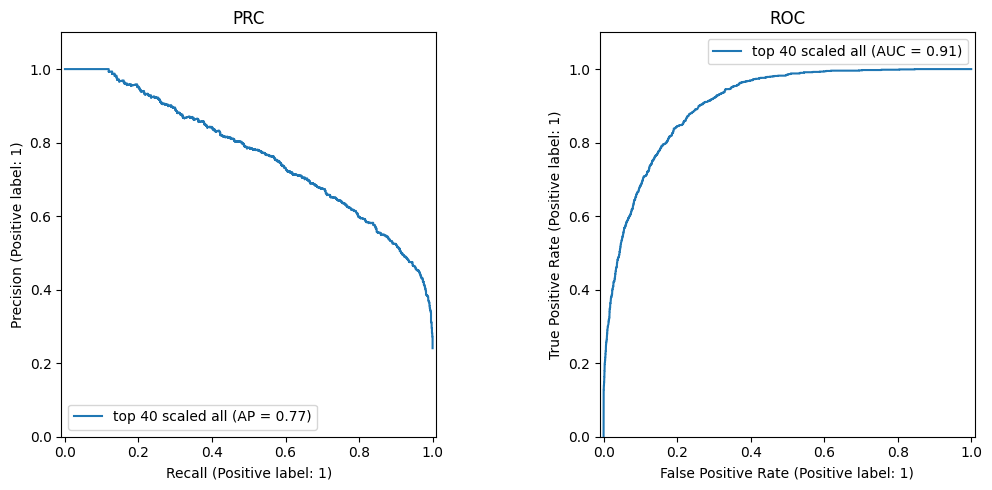

In [1733]:
column_transformer_ohe = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
    ],
    remainder='passthrough'
)
X_ohed = column_transformer_ohe.fit_transform(X_train_)

column_transformer_scale = ColumnTransformer(
     transformers=[('scaling', StandardScaler(), slice(X_ohed.shape[1]))],
     remainder='passthrough'
)

X_train_transform_ = column_transformer_scale.fit_transform(X_ohed.toarray())
X_val_transform_ = column_transformer_scale.transform(column_transformer_ohe.transform(X_val_).toarray())

model = LogisticRegression(max_iter=10000, random_state=42, n_jobs=1)
model.fit(X_train_transform_, y_train_)

w = model.coef_[0].copy()

right_indexes = np.argsort(np.abs(w))[-40:]

model = LogisticRegression(max_iter=10000, random_state=42, n_jobs=1)

model.fit(X_train_transform_[:, right_indexes], y_train_)
prediction = model.decision_function(X_val_transform_[:, right_indexes])
print(f'auc-pr score all scaled: {average_precision_score(y_val_, prediction):.4f}')
print(right_indexes)
depict_pr_roc(y_val, prediction, 'top 40 scaled all')

Списки изменились, качество даже улучшилось, абалдеть

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Чем выше по модулю корреляция, тем более линейная связь между признаком и целевой переменной, поэтому они будут намного лучше влиять на предсказательную способность. Ищем такие признаки.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



auc-pr correlations: 0.7696
time elapsed: 0.0192
top 40 correlation filter metrics
AUC-PR: 0.7696
AUC-ROC: 0.9068


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


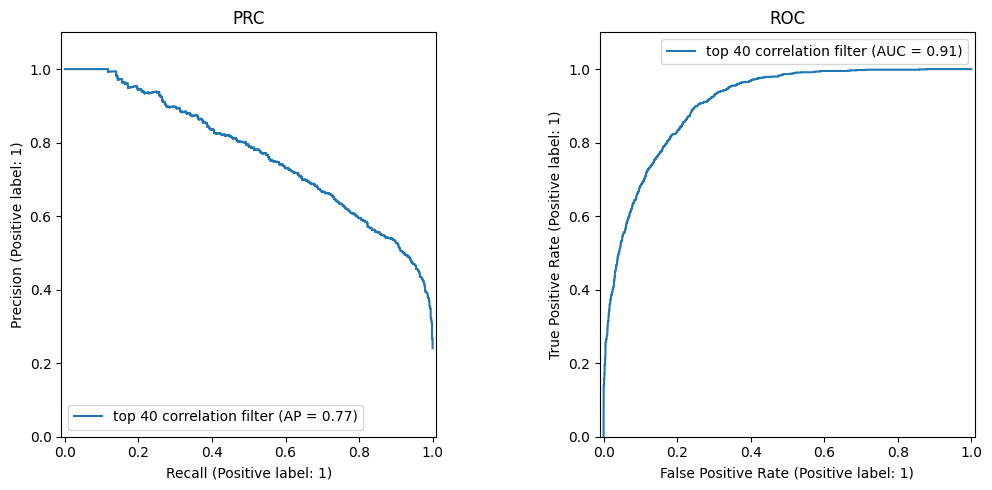

In [1716]:
column_transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
    ],
    remainder='passthrough'
)
X_train_transform = column_transformer.fit_transform(X_train_)
X_val_transform = column_transformer.transform(X_val_)

start = time.time()

correlations = np.abs((X_train_transform - np.mean(X_train_transform, axis=0)).T @ (y_train_ - np.mean(y_train_)) / (np.std(X_train_transform.toarray(), axis=0) * np.std(y_train_) * len(y_train_)))

end = time.time()

right_indexes = np.argsort(abs(np.array(correlations)))[-40:]

model.fit(X_train_transform[:, right_indexes], y_train_)
prediction = model.decision_function(X_val_transform[:, right_indexes])
print(f'auc-pr correlations: {average_precision_score(y_val_, prediction):.4f}')
print(f'time elapsed: {(end - start):.4f}')
depict_pr_roc(y_val, prediction, 'top 40 correlation filter')

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

auc-pr correlations: 0.7671
time elapsed: 0.0106
top 40 t-statistic filter metrics
AUC-PR: 0.7671
AUC-ROC: 0.9028


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


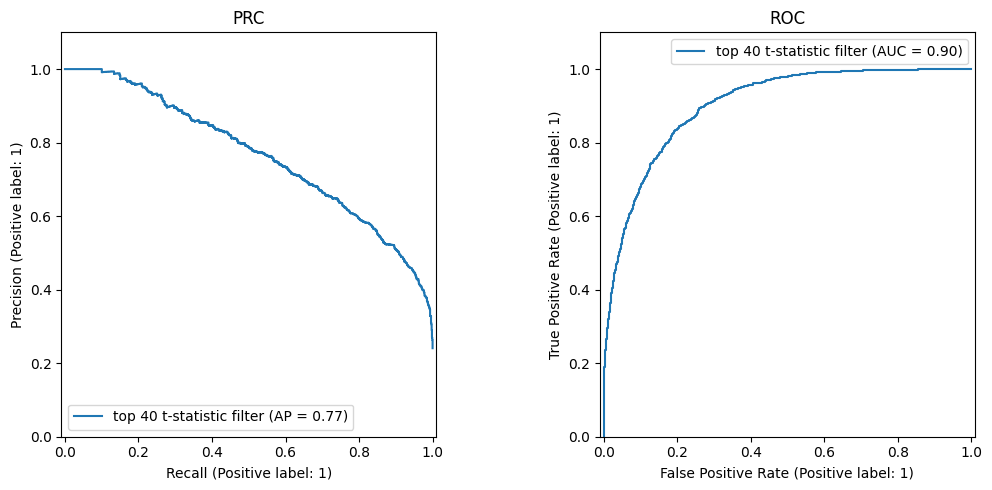

In [1717]:
start = time.time()

mu_plus = np.mean(X_train_transform[y_train_ == 1], axis=0)
mu_minus = np.mean(X_train_transform[y_train_ == 0], axis=0)
sigma_plus2 = np.var(X_train_transform[y_train_ == 1].toarray(), axis=0)
sigma_minus2 =  np.var(X_train_transform[y_train_ == 0].toarray(), axis=0)

t_s = (np.abs(mu_plus - mu_minus) / np.sqrt(y_train_.mean() * sigma_plus2 + (1 - y_train_.mean()) * sigma_minus2))

right_indexes = np.asarray(np.argsort(t_s)[-40:])[0]
end = time.time()

model.fit(X_train_transform[:, right_indexes], y_train_)
prediction = model.decision_function(X_val_transform[:, right_indexes])
print(f'auc-pr correlations: {average_precision_score(y_val_, prediction):.4f}')
print(f'time elapsed: {(end - start):.4f}')
depict_pr_roc(y_val, prediction, 'top 40 t-statistic filter')

Обе фильтрации показали себя лучше чем изначально запомненная нами модель и ее метрика качества 

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

Будем пользоваться методом ohe scale all top 40 

In [1760]:
column_transformer_ohe = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
    ],
    remainder='passthrough'
)
X_ohed = column_transformer_ohe.fit_transform(X_train)

column_transformer_scale = ColumnTransformer(
     transformers=[('scaling', StandardScaler(), slice(X_ohed.shape[1]))],
     remainder='passthrough'
)

X_train_transform_ = column_transformer_scale.fit_transform(X_ohed.toarray())
X_test_transform_ = column_transformer_scale.transform(column_transformer_ohe.transform(X_test).toarray())

features_cnt = X_train_transform.shape[1]
k = 40
m = 4 #признаков много, будем кикать их пачками, тем более у нас они не сильно прыгучие и достаточно равномерные корреляции

start = time.time()

while features_cnt != k:
    model = LogisticRegression(max_iter=10000, random_state=42)
    model.fit(X_train_transform_, y_train)
    w = model.coef_[0].copy()
    
    M = min(X_train_transform_.shape[1] - k, m)

    right_indexes = np.argsort(np.abs(w))[M - features_cnt:]
    
    X_train_transform_ = X_train_transform_[:, right_indexes]
    X_test_transform_ = X_test_transform_[:, right_indexes]
    features_cnt = X_train_transform_.shape[1]
    print(f'Remained: {features_cnt}')
    
end = time.time()
    
print(f'time elapsed: {(end - start)}')


Remained: 104
Remained: 100
Remained: 96
Remained: 92
Remained: 88
Remained: 84
Remained: 80
Remained: 76
Remained: 72
Remained: 68
Remained: 64
Remained: 60
Remained: 56
Remained: 52
Remained: 48
Remained: 44
Remained: 40
time elapsed: 3.541828155517578


auc-pr full scaling down obertka: 0.7663
time elapsed: 3.5418
ohe + scale all full scaling down obertka metrics
AUC-PR: 0.7663
AUC-ROC: 0.9061


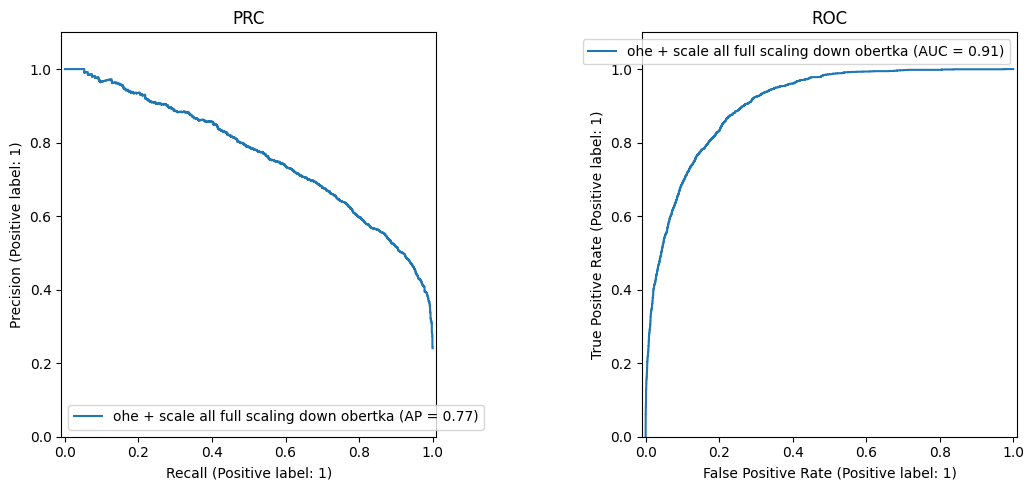

In [1761]:
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train_transform_, y_train)
prediction = model.decision_function(X_test_transform_)
print(f'auc-pr full scaling down obertka: {average_precision_score(y_test, prediction):.4f}')
print(f'time elapsed: {(end - start):.4f}')
depict_pr_roc(y_test, prediction, 'ohe + scale all full scaling down obertka')

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

Он может найтись если мы взяли достаточное количество признаков, но 40 это не очень много, поэтому качество будет расти и расти тем более мы включаем самые важные по критерию ohe scale all, так что мы фигню будем брать только в самом конце, то есть такой порог будет высоким

In [1762]:
column_transformer_ohe = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
    ],
    remainder='passthrough'
)
X_ohed = column_transformer_ohe.fit_transform(X_train)

column_transformer_scale = ColumnTransformer(
     transformers=[('scaling', StandardScaler(), slice(X_ohed.shape[1]))],
     remainder='passthrough'
)

X_train_transform_ = column_transformer_scale.fit_transform(X_ohed.toarray())
X_test_transform_ = column_transformer_scale.transform(column_transformer_ohe.transform(X_test).toarray())

features_cnt = 0
k = 40
m = 4 #добавляем сразу по 4

start = time.time()

while features_cnt != k:
    model = LogisticRegression(max_iter=10000, random_state=42)
    model.fit(X_train_transform_, y_train)
    w = model.coef_[0].copy()

    right_indexes = np.argsort(np.abs(w))[-m:]
    remained_indexes = np.argsort(np.abs(w))[:-m]
    
    if (not features_cnt):
        NewX_train = X_train_transform_[:, right_indexes]
        NewX_test = X_test_transform_[:, right_indexes]
        features_cnt = NewX_train.shape[1]
    else:
        NewX_train = np.concatenate([NewX_train, X_train_transform_[:, right_indexes].reshape((-1, m))], axis=1)
        NewX_test = np.concatenate([NewX_test, X_test_transform_[:, right_indexes].reshape((-1, m))], axis=1)
        features_cnt += m
    X_train_transform_ = X_train_transform_[:, remained_indexes]
    X_test_transform_ = X_test_transform_[:, remained_indexes]

    print(f'Added: {features_cnt}')
    
end = time.time()
    
print(f'time elapsed: {(end - start)}')


Added: 4
Added: 8
Added: 12
Added: 16
Added: 20
Added: 24
Added: 28
Added: 32
Added: 36
Added: 40
time elapsed: 1.391244888305664


auc-pr full scaling up obertka: 0.7608
time elapsed: 1.3912
ohe + scale all full scaling up obertka metrics
AUC-PR: 0.7608
AUC-ROC: 0.9040


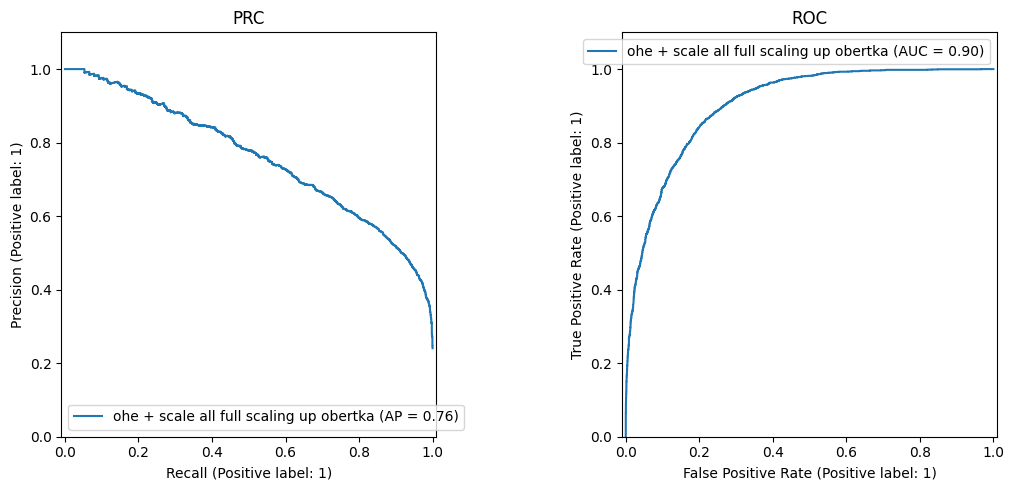

In [1763]:
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(NewX_train, y_train)
prediction = model.decision_function(NewX_test)
print(f'auc-pr full scaling up obertka: {average_precision_score(y_test, prediction):.4f}')
print(f'time elapsed: {(end - start):.4f}')
depict_pr_roc(y_test, prediction, 'ohe + scale all full scaling up obertka')

ohe auc-pr score: 0.7639

embedded method metrics AUC-PR: 0.6734

auc-pr score top40 scaled numeric: 0.741500

top 40 scaled all ohe AUC-PR: 0.7686

auc-pr correlations top 40: 0.7696

top 40 t-statistic filter metrics AUC-PR: 0.7671

ohe + scale all full scaling down obertka AUC-PR: 0.7663

ohe + scale all full scaling up obertka metrics: 0.7608

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Как видим лучшие результаты показали scaled all top40, корреляции топ40, t-statistic filter и близко к хорошему была нисходящая обертка, которая к сожалению долгая

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip


--2024-11-29 15:04:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «bank-additional.zip»

bank-additional.zip     [   <=>              ] 434,15K   451KB/s    за 1,0s    

2024-11-29 15:04:57 (451 KB/s) - «bank-additional.zip» сохранён [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional 

In [1772]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [1870]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [2027]:
categorical = X.select_dtypes('object').columns
numerical = X.select_dtypes('int64').columns
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numerical)
])

logistic_pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=10000, random_state=42))
])

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [2028]:
from collections import defaultdict
from sklearn.model_selection import KFold
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=52,
    shuffle=True,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        model = logistic_pipeline.fit(X.iloc[train_index], y.iloc[train_index])
        y_prob = model.predict_proba(X.iloc[test_index])[:, 1]
        y_pred = model.predict(X.iloc[test_index])
        y_test = y.iloc[test_index]

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "AUC-PR": average_precision_score(y_test, y_prob),
            "AUC-ROC": roc_auc_score(y_test, y_prob)
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics), y_pred, y_test

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [2029]:
metrics1, yp, yt = cross_validate(X, y)
metrics1

,AUC-PR,AUC-ROC
0,0.425753,0.762645
1,0.379036,0.753640
2,0.376339,0.742500
3,0.405560,0.774928
4,0.424511,0.769674


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [2030]:
from collections import defaultdict
from sklearn.model_selection import KFold

def profit(yt, yp):
    return ((yt == 1) & (yp == 1)).sum() * 10 - 2 * (yp == 1).sum()

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=52,
    shuffle=True,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        model = logistic_pipeline.fit(X.iloc[train_index], y.iloc[train_index])
        y_prob = model.predict_proba(X.iloc[test_index])[:, 1]
        y_pred = model.predict(X.iloc[test_index])
        y_test = y.iloc[test_index]

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "AUC-PR": average_precision_score(y_test, y_prob),
            "AUC-ROC": roc_auc_score(y_test, y_prob),
            "Profit": profit(y_test, y_pred),
            "Costs": 2 * (y_pred == 1).sum()
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

In [2031]:
metrics2 = cross_validate(X, y)
metrics2

,AUC-PR,AUC-ROC,Profit,Costs
0,0.425753,0.762645,1282,528
1,0.379036,0.753640,1158,552
2,0.376339,0.742500,1138,562
3,0.405560,0.774928,1066,494
4,0.424511,0.769674,1366,524


In [2032]:
print('Mean profit: ', metrics2['Profit'].mean())
print('Std profit: ', metrics2['Profit'].std())
print('Mean costs: ', metrics2['Costs'].mean())
print('Correlation AUC-ROC: ', metrics2['Profit'].corr(metrics2['AUC-ROC']))
print('Correlation AUC-PR: ', metrics2['Profit'].corr(metrics2['AUC-PR']))

Mean profit:  1202.0
Std profit:  120.2331069215131
Mean costs:  532.0
Correlation AUC-ROC:  0.18790879576073083
Correlation AUC-PR:  0.6774927538150735


Как видим, корреляция намного лушче и адекватнее с AUC-PR, поэтому будем максить ее 

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [2036]:
from collections import defaultdict
from sklearn.model_selection import KFold

def random_profit(yt, yp):
    return np.random.uniform(0, 20, ((yt == 1) & (yp == 1)).sum()).sum() - 2 * (yp == 1).sum()

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=52,
    shuffle=True,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        model = logistic_pipeline.fit(X.iloc[train_index], y.iloc[train_index])
        y_prob = model.predict_proba(X.iloc[test_index])[:, 1]
        y_pred = model.predict(X.iloc[test_index])
        y_test = y.iloc[test_index]

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "AUC-PR": average_precision_score(y_test, y_prob),
            "Rand Profit": random_profit(y_test, y_pred),
            "Costs": 2 * (y_pred == 1).sum()
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

metrics3 = cross_validate(X, y)
metrics3

,AUC-PR,Rand Profit,Costs
0,0.425753,1291.864485,528
1,0.379036,1179.167009,552
2,0.376339,1169.376454,562
3,0.405560,1095.001680,494
4,0.424511,1498.311003,524


In [2055]:
print('Mean profit: ', metrics3['Rand Profit'].mean())
print('Std profit: ', metrics3['Rand Profit'].std())
print('Mean costs: ', metrics3['Costs'].mean())
print('Correlation AUC-PR: ', metrics3['Rand Profit'].corr(metrics3['AUC-PR']))

Mean profit:  1246.7441259631248
Std profit:  157.2417990651775
Mean costs:  532.0
Correlation AUC-PR:  0.6496134586919453


Получать мы стали больше, но это скорее повезло, в принципе средняя прибыль не должна силльно далеко уходить от изначальной после введения случайной величины из-за размеров выборки. 

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [2038]:
def random_profit(yt, yp):
    return np.random.uniform(0, 20, ((yt == 1) & (yp == 1)).sum()).sum() - 2 * (yp == 1).sum()

def cross_validate(
    X,
    y,
    pipeline,
    n_splits=5,
    random_state=52,
    shuffle=True
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        model = pipeline.fit(X.iloc[train_index], y.iloc[train_index])
        y_prob = model.predict_proba(X.iloc[test_index])[:, 1]
        y_pred = model.predict(X.iloc[test_index])
        y_test = y.iloc[test_index]

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "AUC-PR": average_precision_score(y_test, y_prob),
            "Rand Profit": random_profit(y_test, y_pred),
            "Costs": 2 * (y_pred == 1).sum()
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

In [2039]:
cs = np.logspace(-4, 4, 15)

best_profit = 0
best_c = 0

expected_profits = []

for c in cs:
    logistic_pipeline = Pipeline(steps=[
        ('scaling', column_transformer),
        ('regression', LogisticRegression(max_iter=10000, random_state=42, C=c))
    ])

    metrics4 = cross_validate(X, y, logistic_pipeline)
    expected_profit = metrics4['Rand Profit'].mean()
    if expected_profit > best_profit:
        best_c = c
        best_profit = expected_profit

    expected_profits.append(expected_profit)

print(f'Best C: {best_c}, best average profit: {best_profit}')

Best C: 0.005179474679231213, best average profit: 1285.8040960603341


Выигрыш получился, лучшая константа 0.005179474679231213

<function matplotlib.pyplot.show(close=None, block=None)>

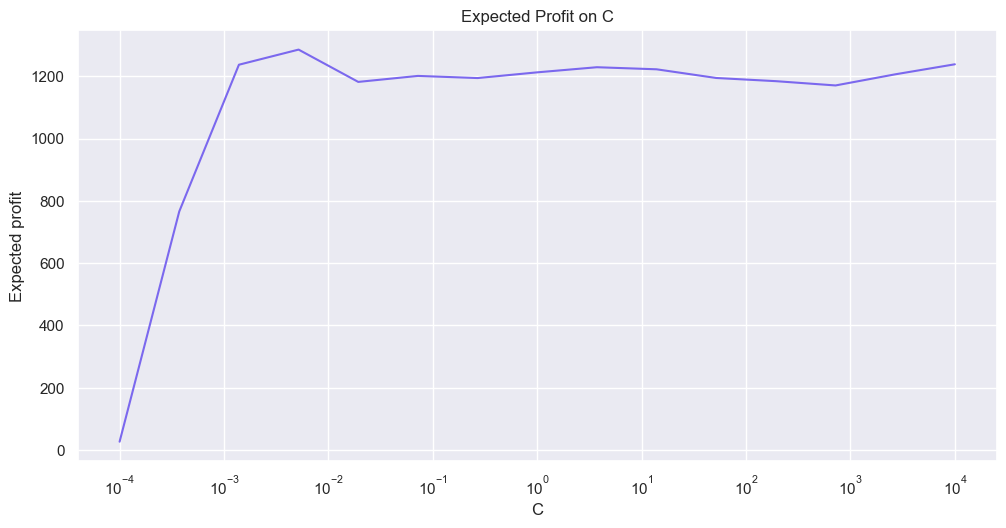

In [2040]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.tight_layout()
sns.set_theme(style="darkgrid")
sns.lineplot(x=cs, y=expected_profits, color='mediumslateblue', ax=ax).set(xscale='log', title='Expected Profit on C', xlabel='C', ylabel='Expected profit')
plt.show

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [2041]:
for _ in range(5):
    cs = np.logspace(-4, 4, 15)

    best_profit = 0
    best_c = 0

    expected_profits = []

    for c in cs:
        logistic_pipeline = Pipeline(steps=[
            ('scaling', column_transformer),
            ('regression', LogisticRegression(max_iter=10000, random_state=42, C=c))
        ])

        metrics5 = cross_validate(X, y, logistic_pipeline)
        expected_profit = metrics5['Rand Profit'].mean()
        if expected_profit > best_profit:
            best_c = c
            best_profit = expected_profit

        expected_profits.append(expected_profit)

    print(f'Best C: {best_c}, best average profit: {best_profit}')

Best C: 0.0013894954943731374, best average profit: 1246.8094038981806
Best C: 10000.0, best average profit: 1292.5869676251662
Best C: 0.0013894954943731374, best average profit: 1275.5113391276877
Best C: 0.2682695795279725, best average profit: 1257.1015295667305
Best C: 0.0013894954943731374, best average profit: 1317.7685572835567


Абсолютно странные рандомные значения, как будто никакой логики нет адекватной 

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Кажется, что precision важнее в нашем случае, так как тогда отношение успешных звонков будет выше и каждое такое увеличение обойдется нам в +8, recallом же мы можем накидать себе -2 и уходить в минус, но в другой задаче (например не максимизации прибыли а привлечение клиентов) recall мог бы сыграть более важную роль 



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [2048]:
from sklearn.metrics import precision_score

def random_profit(yt, yp):
    return np.random.uniform(0, 20, ((yt == 1) & (yp == 1)).sum()).sum() - 2 * (yp == 1).sum()

def cross_validate(
    X,
    y,
    pipeline,
    n_splits=5,
    random_state=52,
    shuffle=True
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        model = pipeline.fit(X.iloc[train_index], y.iloc[train_index])
        y_prob = model.predict_proba(X.iloc[test_index])[:, 1]
        y_test = y.iloc[test_index]
        
        best_profit = 0
        profits = []
        best_treshold = 0
        best_y_pred_binarized = 0
        
        for treshlod in np.linspace(0, 1, 101):
            y_pred_binarized = np.where(y_prob >= treshlod, 1, 0)
            cur_profit = random_profit(y_test, y_pred_binarized)
            profits.append(cur_profit)
            
            if cur_profit > best_profit:
                best_profit = cur_profit
                best_treshold = treshlod
                best_y_pred_binarized = y_pred_binarized
                

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "precision score": precision_score(y_test, best_y_pred_binarized),
            "Rand Profit": best_profit,
            "Costs": 2 * (best_y_pred_binarized == 1).sum(),
            "Threshold": best_treshold
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics), profits

In [2049]:
logistic_pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=10000, random_state=42))
])
metrics6, profits = cross_validate(X, y, logistic_pipeline)
metrics6

,precision score,Rand Profit,Costs,Threshold
0,0.413762,2651.395019,2238,0.17
1,0.379670,2145.329423,2302,0.16
2,0.366667,2397.184801,2580,0.14
3,0.461371,2526.353499,1838,0.19
4,0.552805,2358.980964,1212,0.26


Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




<function matplotlib.pyplot.show(close=None, block=None)>

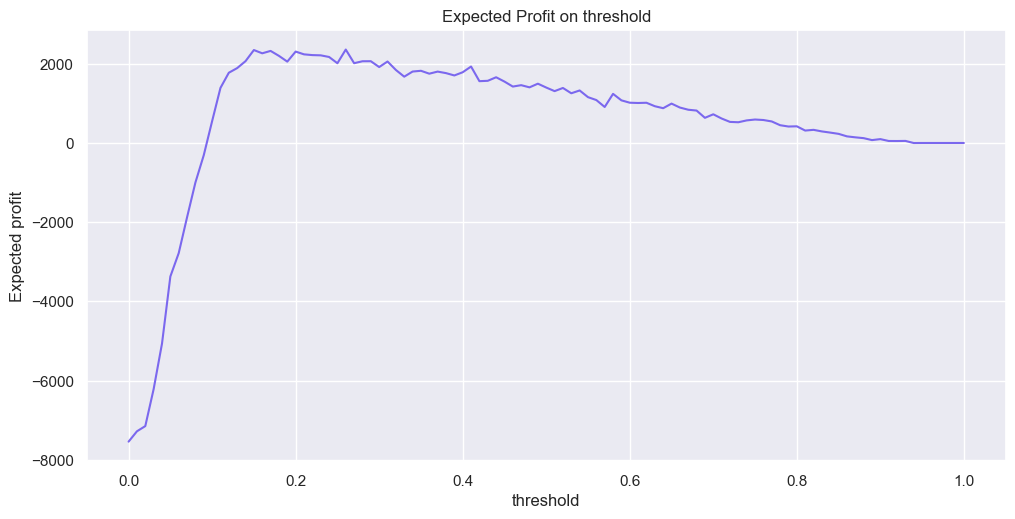

In [2050]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.tight_layout()
sns.set_theme(style="darkgrid")
sns.lineplot(x=np.linspace(0, 1, 101), y=profits, color='mediumslateblue', ax=ax).set(title='Expected Profit on threshold', xlabel='threshold', ylabel='Expected profit')
plt.show

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Как можно видеть оптимальный порог находится в районе 0,2 потому что выигрыш от правильных проггноз превышают издержки ровно в 5 раз, мвозможно из-за этого имеет смысл снизить порог и объявлять всехб что выше положительными, как условие оптимальноси выручка = издержки 

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [2053]:
print('Mean profit: ', metrics6['Rand Profit'].mean())
print('Std profit: ', metrics6['Rand Profit'].std())
print('Mean costs: ', metrics6['Costs'].mean())
print('Correlation AUC-PR: ', metrics6['Rand Profit'].corr(metrics6['precision score']))

Mean profit:  2415.848741168878
Std profit:  190.03706141132687
Mean costs:  2034.0
Correlation AUC-PR:  0.13003843620937222


In [2061]:
from scipy.stats import ttest_ind, ttest_rel

t_res = ttest_ind(metrics2['Profit'], metrics6['Rand Profit'])
print(t_res.pvalue)
print(ttest_rel(metrics2['Profit'], metrics6['Rand Profit']))

2.051053641003278e-06
TtestResult(statistic=-12.549695506156985, pvalue=0.000231982451439792, df=4)


Очевидно прибыль по второй модели выше 

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ # your answer here